In [1]:
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat 
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_selection import f_regression, f_oneway, RFE, RFECV
from sklearn.decomposition import PCA
import mlflow
from mlflow.models import infer_signature
import dagshub
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score
import xgboost as xgb

In [8]:
df = pd.read_excel(io="./Copper_Set.xlsx")

In [9]:
df.head()

,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,20210401.0,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,DEQ1 S460MC,1670798778,20210701.0,854.00
1,4E5F4B3D-DDDF-499D-AFDE-A3227EC49425,20210401.0,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,0000000000000000000000000000000000104991,1668701718,20210401.0,1047.00
2,E140FF1B-2407-4C02-A0DD-780A093B1158,20210401.0,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,S0380700,628377,20210101.0,644.33
3,F8D507A0-9C62-4EFE-831E-33E1DA53BB50,20210401.0,202.411065,30349574.0,32.0,Won,S,59.0,2.30,1317.0,DX51D+ZM310MAO 2.3X1317,1668701718,20210101.0,768.00
4,4E1C4E78-152B-430A-8094-ADD889C9D0AD,20210401.0,785.526262,30211560.0,28.0,Won,W,10.0,4.00,2000.0,2_S275JR+AR-CL1,640665,20210301.0,577.00


In [106]:
regression_data = df[["item type", "application", "thickness", "width", "material_ref", "product_ref", "delivery date", "selling_price"]]

In [107]:
regression_data.isnull().sum()

item type            0
application         24
thickness            1
width                0
material_ref     77919
product_ref          0
delivery date        1
selling_price        1
dtype: int64

In [85]:
from sklearn.impute import KNNImputer

In [86]:
regression_data[["application", "thickness", "delivery date", "selling_price"]] = KNNImputer().fit_transform(regression_data[["application", "thickness", "delivery date", "selling_price"]])

In [87]:
regression_data.isnull().sum()

item type            0
application          0
thickness            0
width                0
material_ref     77919
product_ref          0
delivery date        0
selling_price        0
dtype: int64

In [88]:
regression_data["delivery_date_year"] = regression_data["delivery date"].astype(int).astype(str).str.slice(0,4).astype(int)
regression_data["delivery_date_month"] = regression_data["delivery date"].astype(int).astype(str).str.slice(4,6).astype(int)
regression_data["delivery_date_day"] = regression_data["delivery date"].astype(int).astype(str).str.slice(6,8).astype(int)

In [89]:
# regression_data[regression_data["delivery_date_year"] == 3031]
regression_data = regression_data[~(regression_data["delivery_date_month"] == 22)]
# regression_data["delivery_date_month"].unique()

In [90]:
regression_data.drop(labels=["material_ref", "product_ref", "delivery date"], axis=1, inplace=True)

In [91]:
regression_data["application"] = regression_data["application"].map(regression_data["application"].value_counts(normalize=True).to_dict())

In [92]:
regression_data["item type"] = regression_data["item type"].map(regression_data["item type"].value_counts(normalize=True).to_dict())

In [19]:
Q1 = regression_data["width"].quantile(0.25)
print("Q1 (25 % perecntile)", Q1)
Q3 = regression_data["width"].quantile(0.75)
print("Q3 (75 % perecntile)", Q3)
IQR = Q3 - Q1
IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("lower bound", lower_bound)
print("upper bound", upper_bound)
regression_data["width"] = (np.where(regression_data["width"] > upper_bound, 
                                                upper_bound, np.where(regression_data["width"] < lower_bound, 
                                                lower_bound, regression_data["width"])))

# regression_data[(regression_data["width"] < lower_bound) | (regression_data["width"] > upper_bound)]["width"]

Q1 (25 % perecntile) 1180.0
Q3 (75 % perecntile) 1500.0
lower bound 700.0
upper bound 1980.0


In [20]:
Q1 = regression_data["thickness"].quantile(0.25)
print("Q1 (25 % perecntile)", Q1)
Q3 = regression_data["thickness"].quantile(0.75)
print("Q3 (75 % perecntile)", Q3)
IQR = Q3 - Q1
IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("lower bound", lower_bound)
print("upper bound", upper_bound)
regression_data["thickness"] = (np.where(regression_data["thickness"] > upper_bound, 
                                                upper_bound, np.where(regression_data["thickness"] < lower_bound, 
                                                lower_bound, regression_data["thickness"])))

# regression_data[(regression_data["width"] < lower_bound) | (regression_data["width"] > upper_bound)]["width"]

Q1 (25 % perecntile) 0.7
Q3 (75 % perecntile) 3.0
lower bound -2.75
upper bound 6.449999999999999


In [129]:
# lower_width_limit = regression_data["width"].mean() - 3 * regression_data["width"].std()
# upper_width_limit = regression_data["width"].mean() + 3 * regression_data["width"].std()
# # lower_width_limit, upper_width_limit 
# lower_thickness_limit = regression_data["thickness"].mean() - 3 * regression_data["thickness"].std()
# upper_thickness_limit = regression_data["thickness"].mean() + 3 * regression_data["thickness"].std()
# # lower_thickness_limit, upper_thickness_limit 
# regression_data["thickness"] = (np.where(regression_data["thickness"] > upper_thickness_limit, 
#                                                 upper_thickness_limit, np.where(regression_data["thickness"] < lower_thickness_limit, 
#                                                 lower_thickness_limit, regression_data["thickness"])))
# regression_data["width"] = (np.where(regression_data["width"] > upper_width_limit, 
#                                                 upper_width_limit, np.where(regression_data["width"] < lower_width_limit, 
#                                                 lower_width_limit, regression_data["width"])))

In [160]:
import seaborn as sns

<Axes: ylabel='thickness'>

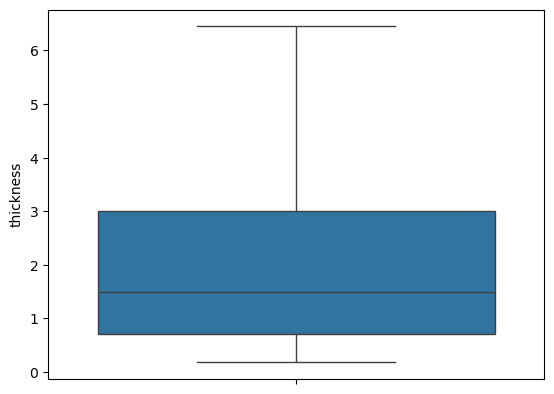

In [216]:
sns.boxplot(regression_data["thickness"])

<Axes: ylabel='width'>

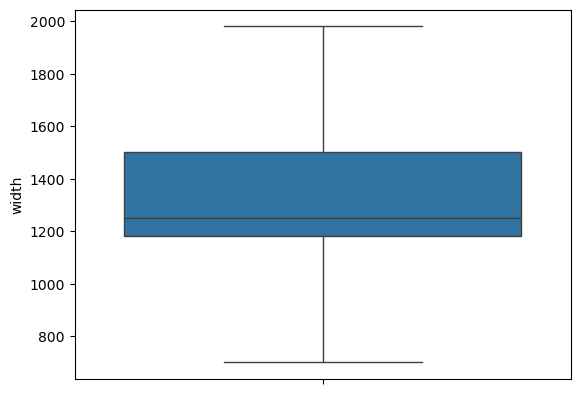

In [176]:
sns.boxplot(regression_data["width"])

In [93]:
from feature_engine.creation import CyclicalFeatures

In [94]:
cyclical_features = CyclicalFeatures().fit_transform(regression_data[["delivery_date_year", "delivery_date_month"]])

In [95]:
cyclical_features = cyclical_features[["delivery_date_year_sin", "delivery_date_year_cos", "delivery_date_month_sin", "delivery_date_month_cos"]] 
cyclical_features

,delivery_date_year_sin,delivery_date_year_cos,delivery_date_month_sin,delivery_date_month_cos
0,-0.866371,-0.499401,-0.500000,-8.660254e-01
1,-0.866371,-0.499401,0.866025,-5.000000e-01
2,-0.866371,-0.499401,0.500000,8.660254e-01
3,-0.866371,-0.499401,0.500000,8.660254e-01
4,-0.866371,-0.499401,1.000000,6.123234e-17
...,...,...,...,...
181668,-0.865334,-0.501196,-0.500000,-8.660254e-01
181669,-0.865334,-0.501196,-0.500000,-8.660254e-01
181670,-0.865334,-0.501196,-0.500000,-8.660254e-01
181671,-0.865334,-0.501196,-0.500000,-8.660254e-01


In [96]:
regression_data[["delivery_date_year_sin", "delivery_date_year_cos", "delivery_date_month_sin", "delivery_date_month_cos"]] = cyclical_features[["delivery_date_year_sin", "delivery_date_year_cos", "delivery_date_month_sin", "delivery_date_month_cos"]]

In [97]:
regression_data.drop(labels=["delivery_date_year", "delivery_date_month", "delivery_date_day"], axis=1, inplace=True)

In [98]:
regression_data.head()

,item type,application,thickness,width,selling_price,delivery_date_year_sin,delivery_date_year_cos,delivery_date_month_sin,delivery_date_month_cos
0,0.581350,0.426841,2.00,1500.0,854.00,-0.866371,-0.499401,-0.500000,-8.660254e-01
1,0.581350,0.254640,0.80,1210.0,1047.00,-0.866371,-0.499401,0.866025,-5.000000e-01
2,0.002884,0.008758,0.38,952.0,644.33,-0.866371,-0.499401,0.500000,8.660254e-01
3,0.381099,0.049138,2.30,1317.0,768.00,-0.866371,-0.499401,0.500000,8.660254e-01
4,0.581350,0.426841,4.00,2000.0,577.00,-0.866371,-0.499401,1.000000,6.123234e-17


In [224]:
print(regression_data["width"].skew())
print(regression_data["thickness"].skew())

0.6676539489549043
1.0609293701756861


In [137]:
from sklearn.preprocessing import PowerTransformer, FunctionTransformer

In [138]:
regression_data[regression_data["width"] < 0]

,item type,application,thickness,width,selling_price,delivery_date_year_sin,delivery_date_year_cos,delivery_date_month_sin,delivery_date_month_cos


In [139]:
# FunctionTransformer(func=np.log2).fit_transform(regression_data["thickness"]).skew()

0.34759969983709665

In [148]:
# regression_data["thickness"] = FunctionTransformer(func=np.log2).fit_transform(regression_data["thickness"])

-0.5788899050518048

In [225]:
regression_data[["thickness", "width"]] = PowerTransformer().fit_transform(regression_data[["thickness", "width"]])

In [226]:
regression_data.head()

,item type,application,thickness,width,selling_price,delivery_date_year_sin,delivery_date_year_cos,delivery_date_month_sin,delivery_date_month_cos
0,0.581350,0.426841,0.289046,0.853118,854.00,-0.866371,-0.499401,-0.500000,-8.660254e-01
1,0.581350,0.254640,-0.812440,-0.284493,1047.00,-0.866371,-0.499401,0.866025,-5.000000e-01
2,0.002884,0.008758,-1.525446,-1.505685,644.33,-0.866371,-0.499401,0.500000,8.660254e-01
3,0.381099,0.049138,0.461370,0.159183,768.00,-0.866371,-0.499401,0.500000,8.660254e-01
4,0.581350,0.426841,1.112299,2.386704,577.00,-0.866371,-0.499401,1.000000,6.123234e-17


In [99]:
X = regression_data.drop(labels=["selling_price"], axis=1)
y = regression_data["selling_price"]

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [101]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train[X_train.columns] = scaler.transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [102]:
X_train

,item type,application,thickness,width,delivery_date_year_sin,delivery_date_year_cos,delivery_date_month_sin,delivery_date_month_cos
0,-0.781087,-0.938175,0.449149,0.439583,-0.138305,0.132704,0.633133,-1.208362
1,-3.433833,1.010476,-0.074854,0.133594,0.280468,-0.285757,-1.503734,0.011397
2,-0.781087,1.010476,-0.271356,-1.029163,-0.138305,0.132704,0.633133,1.231155
3,-0.781087,-0.063302,-0.262186,-0.172394,-0.138305,0.132704,0.633133,-1.208362
4,0.736914,-0.063302,-0.107605,-0.746123,-0.138305,0.132704,0.633133,1.231155
...,...,...,...,...,...,...,...,...
127165,0.736914,-1.628593,1.235154,0.783821,-0.138305,0.132704,0.633133,1.231155
127166,0.736914,1.010476,-0.245155,-0.172394,-0.138305,0.132704,0.633133,1.231155
127167,0.736914,-0.063302,-0.135115,-1.075061,0.280468,-0.285757,-1.312877,0.715625
127168,0.736914,-1.602335,-0.074854,0.045623,0.280468,-0.285757,-1.312877,0.715625


In [40]:
dagshub.init(repo_owner="naveenkrishnan840", repo_name="DS-Copper-modelling-ML", mlflow=True)

Accessing as naveenkrishnan840

Initialized MLflow to track repo "naveenkrishnan840/DS-Copper-modelling-ML"

Repository naveenkrishnan840/DS-Copper-modelling-ML initialized!

In [41]:
mlflow.set_experiment(experiment_id="3")

<Experiment: artifact_location='mlflow-artifacts:/5e6499fc42c540ffa164d4f4450963e1', creation_time=1726996951658, experiment_id='3', last_update_time=1726996951658, lifecycle_stage='active', name='DS-Copper-Modelling-Regression-Task', tags={}>

In [199]:
XGBRegressorParams = {
    # "n_estimators": [1000, 1500],
    "learning_rate": [0.2, 0.3, 0.4],
    "subsample": [0.2, 0.3, 0.4, 0.6, 0.8],
    "booster": ["gbtree", "gblinear", "dart"],
    "max_depth": [28, 32, 64],
    "max_leaves": [28, 32, 64],
    "random_state": [10, 20, 30, 40, 50],
    "num_parallel_tree": [5, 6, 7, 8, 9, 10],
    "grow_policy": ["depthwise", "lossguide"],
    "reg_alpha": [0.2, 0.5, 1.0, 1.5, 2.0, 2.5, 4.5, 6.6], # L1 regulaization
    "reg_lambda" : [1, 5, 10, 20, 50, 80], # L2 regulaization
    "gamma": [0.1, 0.2, 0.3, 0.4, 0.5],
    "importance_type": ["gain", "weight", "cover", "total_gain", "total_cover"],
    "gamma": [5, 10, 15, 20],
    "min_child_weight": [10, 20, 30, 40, 50],
    "multi_strategy": ["one_output_per_tree", "multi_output_tree"],

    # "max_bin": [100, 155, 255]

}

In [ ]:
with mlflow.start_run(experiment_id="3", run_name="XGBRegressor-1") as run_2:
    mlflow.sklearn.autolog()
    mlflow.doctor()
    XGBRegressorModel = xgb.XGBRegressor(n_estimators=1500, base_score=1604.1668761500355, objective="reg:squarederror", verbosity=3, booster="dart", 
                                         tree_method="hist")
    XGBRegressorModel_cv = RandomizedSearchCV(estimator=XGBRegressorModel, param_distributions=XGBRegressorParamss, verbose=3, n_jobs=-1, 
                    cv=KFold(n_splits=25, shuffle=True, random_state=None), random_state=99, n_iter=3)
    XGBRegressorModel_cv.fit(X_train, y_train)
    y_pred = XGBRegressorModel_cv.predict(X_test)
    mlflow.log_metric("testing_mean_squared_error", mean_squared_error(y_true=y_test, y_pred=y_pred))
    mlflow.log_metric("testing_mean_absolute_error", mean_absolute_error(y_true=y_test, y_pred=y_pred))
    mlflow.log_metric("testing_root_mean_squared_error", root_mean_squared_error(y_true=y_test, y_pred=y_pred))
    mlflow.log_metric("testing_r2_score", r2_score(y_true=y_test, y_pred=y_pred))

    signature = infer_signature(X_test, y_pred)

    # # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=XGBRegressorModel_cv,
        artifact_path="XGBRegressor-1",
        signature=signature,
        input_example=X_train,
        registered_model_name="Regression-Task",
    )

In [300]:
model = xgb.XGBRFRegressor(base_score=1604.1668761500355, eta = 1, learning_rate=1.5,
num_round = 5000,
nthread = 16,
min_child_weight = 1000,
tree_method = "hist",
grow_policy = "lossguide",
max_depth = 500,
max_leaves = 255)

In [301]:
model.fit(X_train, y_train)

XGBRFRegressor(base_score=1604.1668761500355, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False, eta=1,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy='lossguide', importance_type=None,
               interaction_constraints=None, learning_rate=1.5, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=500, max_leaves=255,
               min_child_weight=1000, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None, nthread=16,
               num_parallel_tree=None, ...)

In [302]:
r2_score(y_test, model.predict(X_test))

-0.0003024336801284999

In [245]:
X_test

,item type,application,thickness,width,delivery_date_year_sin,delivery_date_year_cos,delivery_date_month_sin,delivery_date_month_cos
0,0.736914,-0.063302,-1.344292,-0.130459,-0.138305,0.132704,1.154565,-0.692831
1,0.736914,1.010476,-1.288303,-0.113720,-0.138305,0.132704,1.154565,-0.692831
2,0.736914,-1.484811,1.112109,-1.782317,-0.138305,0.132704,0.633133,1.231155
3,-0.781087,-0.938175,-0.955437,-0.113720,-0.138305,0.132704,0.633133,1.231155
4,0.736914,-0.063302,-1.353798,-0.072065,-0.138305,0.132704,1.154565,-0.692831
...,...,...,...,...,...,...,...,...
54497,0.736914,-0.938175,1.112109,2.386516,0.280468,-0.285757,-1.503734,0.011397
54498,-0.781087,-1.450076,-0.067137,0.853808,-0.138305,0.132704,1.154565,-0.692831
54499,-0.781087,1.010476,-0.704480,-0.261720,0.280468,-0.285757,-0.791445,-1.208362
54500,-0.781087,-1.344737,0.158877,-1.782317,0.280468,-0.285757,-1.312877,-0.692831


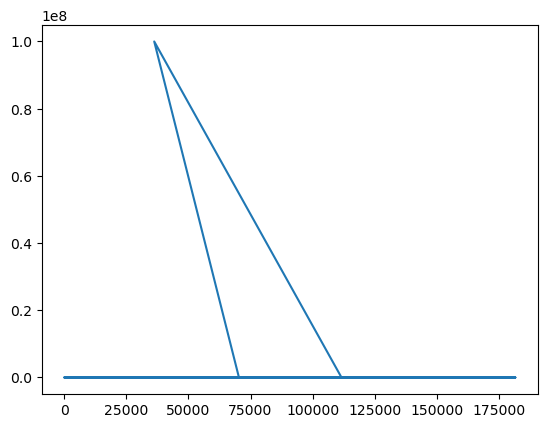

In [50]:
plt.plot(y_train)

In [39]:
import lightgbm as lgb

In [103]:
model = lgb.LGBMRegressor()

In [78]:
X_train = X_train.drop("width", axis=1)
X_test = X_test.drop("width", axis=1)

In [79]:
X_train

,item type,application,thickness,delivery_date_year_sin,delivery_date_year_cos,delivery_date_month_sin,delivery_date_month_cos
0,-0.781087,-0.938175,1.984673,-0.138305,0.132704,0.633133,-1.208362
1,-3.433833,1.010476,-0.129676,0.280468,-0.285757,-1.503734,0.011397
2,-0.781087,1.010476,-0.922557,-0.138305,0.132704,0.633133,1.231155
3,-0.781087,-0.063302,-0.885556,-0.138305,0.132704,0.633133,-1.208362
4,0.736914,-0.063302,-0.261823,-0.138305,0.132704,0.633133,1.231155
...,...,...,...,...,...,...,...
127165,0.736914,-1.628593,2.222538,-0.138305,0.132704,0.633133,1.231155
127166,0.736914,1.010476,-0.816840,-0.138305,0.132704,0.633133,1.231155
127167,0.736914,-0.063302,-0.372826,0.280468,-0.285757,-1.312877,0.715625
127168,0.736914,-1.602335,-0.129676,0.280468,-0.285757,-1.312877,0.715625


In [104]:
model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 127170, number of used features: 8
[LightGBM] [Info] Start training from score 1604.166884


LGBMRegressor()

In [81]:
mean_squared_error(y_train, model.predict(X_train))

69384089645.81306

In [82]:
np.sqrt(r2_score(y_train, model.predict(X_train)))

0.3429872310010144

In [105]:
r2_score(y_test, model.predict(X_test))

-0.0027792718831280983

In [ ]:
dagshub.init(repo_owner='naveenkrishnan840', repo_name='DS-Copper-modelling-ML', mlflow=True)

Accessing as naveenkrishnan840

Initialized MLflow to track repo "naveenkrishnan840/DS-Copper-modelling-ML"

Repository naveenkrishnan840/DS-Copper-modelling-ML initialized!

In [ ]:
mlflow.set_experiment(experiment_id="3")

<Experiment: artifact_location='mlflow-artifacts:/5e6499fc42c540ffa164d4f4450963e1', creation_time=1726996951658, experiment_id='3', last_update_time=1726996951658, lifecycle_stage='active', name='DS-Copper-Modelling-Regression-Task', tags={}>

In [ ]:
mlflow.get_tracking_uri()

'https://dagshub.com/naveenkrishnan840/DS-Copper-modelling-ML.mlflow'

In [ ]:
ElasticNetParams = {
    "alpha": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7 ,0.8, 0.9],
    "l1_ratio": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7 ,0.8, 0.9],
    "tol": [0.004, 0.0004, 0.00004,0.000004,],
    "random_state": list(range(10, 50)),
    "selection": ["cyclic", "random"],
    "max_iter": [1500, 2000, 2500]
}

In [ ]:
with mlflow.start_run(experiment_id="3", run_name="ElasticNet-1") as run_1:
    mlflow.sklearn.autolog()
    mlflow.doctor()
    elastcinet_cv = RandomizedSearchCV(estimator=ElasticNet(), param_distributions=ElasticNetParams, 
                                   cv=KFold(n_splits=25, shuffle=True, random_state=None), n_iter=20, 
                                   verbose=3, n_jobs=-1)
    elastcinet_cv.fit(X_train, y_train)
    y_pred = elastcinet_cv.predict(X_test)
    mlflow.log_metric("testing_mean_squared_error", mean_squared_error(y_true=y_test, y_pred=y_pred))
    mlflow.log_metric("testing_mean_absolute_error", mean_absolute_error(y_true=y_test, y_pred=y_pred))
    mlflow.log_metric("testing_root_mean_squared_error", root_mean_squared_error(y_true=y_test, y_pred=y_pred))
    mlflow.log_metric("testing_r2_score", r2_score(y_true=y_test, y_pred=y_pred))

    signature = infer_signature(X_test, y_pred)

    # # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=elastcinet_cv,
        artifact_path="Elastic-Net-1",
        signature=signature,
        input_example=X_train,
        registered_model_name="Regression-Task",
    )
    

2024/09/22 14:53:36 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.1, but the installed version is 1.5.2. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


System information: Windows 10.0.22631
Python version: 3.12.5
MLflow version: 2.16.2
MLflow module location: C:\Users\NavaneethanJeyapraka\AppData\Roaming\Python\Python312\site-packages\mlflow\__init__.py
Tracking URI: https://dagshub.com/naveenkrishnan840/DS-Copper-modelling-ML.mlflow
Registry URI: https://dagshub.com/naveenkrishnan840/DS-Copper-modelling-ML.mlflow
Active experiment ID: 3
Active run ID: 6982cf1cc267417abcc5f1825b420da2
Active run artifact URI: mlflow-artifacts:/5e6499fc42c540ffa164d4f4450963e1/6982cf1cc267417abcc5f1825b420da2/artifacts
MLflow environment variables: 
  MLFLOW_TRACKING_PASSWORD: 6602c43190bbbd93140e6846d47f88777f01baae
  MLFLOW_TRACKING_URI: https://dagshub.com/naveenkrishnan840/DS-Copper-modelling-ML.mlflow
  MLFLOW_TRACKING_USERNAME: 6602c43190bbbd93140e6846d47f88777f01baae
MLflow dependencies: 
  Flask: 3.0.3
  Jinja2: 3.1.4
  alembic: 1.13.2
  boto3: 1.35.19
  botocore: 1.35.19
  docker: 7.1.0
  graphene: 3.3
  markdown: 3.7
  matplotlib: 3.9.2
  ml

2024/09/22 14:54:40 INFO mlflow.sklearn.utils: Logging the 5 best runs, 15 runs will be omitted.
Successfully registered model 'Regression Task'.
2024/09/22 14:55:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Regression Task, version 1
Created version '1' of model 'Regression Task'.


2024/09/22 14:55:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run ElasticNet-1 at: https://dagshub.com/naveenkrishnan840/DS-Copper-modelling-ML.mlflow/#/experiments/3/runs/6982cf1cc267417abcc5f1825b420da2.
2024/09/22 14:55:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/naveenkrishnan840/DS-Copper-modelling-ML.mlflow/#/experiments/3.


In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
AdaBoostRegressor_params = {
    "n_estimators": [2000, 4000, 6000, 8000],
    "learning_rate": [0.1, 0.2, 0.3, 0.4, 0.5],
    "random_state": list(range(10, 50))
}

In [ ]:
with mlflow.start_run(experiment_id="3", run_name="AdaBoostRegression-3") as run_2:
    mlflow.sklearn.autolog()
    mlflow.doctor()
    adaBoostregressor = RandomizedSearchCV(estimator=AdaBoostRegressor(
        estimator=DecisionTreeRegressor(criterion="friedman_mse",max_depth=32, min_samples_split=256, 
                                        min_samples_leaf=256, max_leaf_nodes=32)
    ), param_distributions=AdaBoostRegressor_params, 
                                   cv=KFold(n_splits=25, shuffle=True, random_state=None), n_iter=30, 
                                   verbose=3, n_jobs=-1)
    adaBoostregressor.fit(X_train, y_train)
    y_pred = adaBoostregressor.predict(X_test)
    mlflow.log_metric("testing_mean_squared_error", mean_squared_error(y_true=y_test, y_pred=y_pred))
    mlflow.log_metric("testing_mean_absolute_error", mean_absolute_error(y_true=y_test, y_pred=y_pred))
    mlflow.log_metric("testing_root_mean_squared_error", root_mean_squared_error(y_true=y_test, y_pred=y_pred))
    mlflow.log_metric("testing_r2_score", r2_score(y_true=y_test, y_pred=y_pred))

    signature = infer_signature(X_test, y_pred)

    # # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=adaBoostregressor,
        artifact_path="AdaBoostRegression-3",
        signature=signature,
        input_example=X_train,
        registered_model_name="Regression-Task",
    )
    

2024/09/22 16:13:46 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.1, but the installed version is 1.5.2. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


System information: Windows 10.0.22631
Python version: 3.12.5
MLflow version: 2.16.2
MLflow module location: C:\Users\NavaneethanJeyapraka\AppData\Roaming\Python\Python312\site-packages\mlflow\__init__.py
Tracking URI: https://dagshub.com/naveenkrishnan840/DS-Copper-modelling-ML.mlflow
Registry URI: https://dagshub.com/naveenkrishnan840/DS-Copper-modelling-ML.mlflow
Active experiment ID: 3
Active run ID: 9b93121e1c5d4f3eb65d2c7c4632208a
Active run artifact URI: mlflow-artifacts:/5e6499fc42c540ffa164d4f4450963e1/9b93121e1c5d4f3eb65d2c7c4632208a/artifacts
MLflow environment variables: 
  MLFLOW_TRACKING_PASSWORD: 6602c43190bbbd93140e6846d47f88777f01baae
  MLFLOW_TRACKING_URI: https://dagshub.com/naveenkrishnan840/DS-Copper-modelling-ML.mlflow
  MLFLOW_TRACKING_USERNAME: 6602c43190bbbd93140e6846d47f88777f01baae
MLflow dependencies: 
  Flask: 3.0.3
  Jinja2: 3.1.4
  alembic: 1.13.2
  boto3: 1.35.19
  botocore: 1.35.19
  docker: 7.1.0
  graphene: 3.3
  markdown: 3.7
  matplotlib: 3.9.2
  ml

2024/09/22 16:44:36 INFO mlflow.sklearn.utils: Logging the 5 best runs, 25 runs will be omitted.
Registered model 'Regression-Task' already exists. Creating a new version of this model...
2024/09/22 16:45:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Regression-Task, version 3
Created version '3' of model 'Regression-Task'.


2024/09/22 16:45:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run AdaBoostRegression-3 at: https://dagshub.com/naveenkrishnan840/DS-Copper-modelling-ML.mlflow/#/experiments/3/runs/9b93121e1c5d4f3eb65d2c7c4632208a.
2024/09/22 16:45:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/naveenkrishnan840/DS-Copper-modelling-ML.mlflow/#/experiments/3.


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

In [ ]:
HistGradientBoostingRegressorParams = {
    "loss": ["quantile"],
    "quantile": [0.1, 0.2, 0.3, 0.4, 0.5],
    "max_iter": [5000, 6000, 7000],
    "learning_rate": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
    "max_leaf_nodes": [25, 50, 75],
    "max_depth": list(range(28, 32)),
    "min_samples_leaf": [64, 128, 256, 512],
    "l2_regularization": [0.1, 0.2, 0.3, 0.4, 0.5],
    "max_bins": [100, 150, 255],
    "interaction_cst": ["pairwise", "no_interactions"],
    "random_state": list(range(10, 50))
}

In [ ]:
with mlflow.start_run(experiment_id="3", run_name="HistGradientBoostingRegressor-4") as run_2:
    mlflow.sklearn.autolog()
    mlflow.doctor()
    histgradientboostingregressorcv = RandomizedSearchCV(estimator=HistGradientBoostingRegressor(), 
                                                         param_distributions=HistGradientBoostingRegressorParams, 
                                   cv=KFold(n_splits=30, shuffle=True, random_state=None), n_iter=30, 
                                   verbose=3, n_jobs=-1)
    histgradientboostingregressorcv.fit(X_train, y_train)
    y_pred = histgradientboostingregressorcv.predict(X_test)
    mlflow.log_metric("testing_mean_squared_error", mean_squared_error(y_true=y_test, y_pred=y_pred))
    mlflow.log_metric("testing_mean_absolute_error", mean_absolute_error(y_true=y_test, y_pred=y_pred))
    mlflow.log_metric("testing_root_mean_squared_error", root_mean_squared_error(y_true=y_test, y_pred=y_pred))
    mlflow.log_metric("testing_r2_score", r2_score(y_true=y_test, y_pred=y_pred))

    signature = infer_signature(X_test, y_pred)

    # # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=histgradientboostingregressorcv,
        artifact_path="HistGradientBoostingRegressor-4",
        signature=signature,
        input_example=X_train,
        registered_model_name="Regression-Task",
    )

In [ ]:
XGBRegressorParams = {
    "n_estimators": [1000, 1500, 2000, 2500],
    "learning_rate": [0.1, 0.9],
    "subsample": [0.2, 0.4, 0.6, 0.8, 0.9],
    "booster": ["gbtree", "gblinear", "dart"],
    "max_depth": [28, 32],
    "max_features": ["sqrt", "log2", None],
    "max_leaves": [28, 32],
    "random_state": list(range(10, 50)),
    "num_parallel_tree": list(range(5, 10)),
    "grow_policy": ["depthwise", "lossguide"],
    "reg_alpha": [0.2, 0.5, 1.0, 1.5, 2.0, 2.5], # L1 regulaization
    "reg_lambda" : [1, 5, 10, 20, 50], # L2 regulaization
    "gamma": [0.1, 0.9],
    "importance_type": ["gain", "weight", "cover", "total_gain", "total_cover"],
    "gamma": [5, 10, 15, 20],
    "min_child_weight": list(range(10, 50)),
    "multi_strategy": ["one_output_per_tree", "multi_output_tree"],

    # "max_bin": [100, 155, 255]

}

In [ ]:
XGBRegressorModel = xgb.XGBRegressor(base_score=815.359900374907, objective="reg:squarederror", verbosity=3, booster="dart", tree_method="approx")
XGBRegressorModel_cv = RandomizedSearchCV(estimator=XGBRegressorModel, param_distributions=XGBRegressorParams, verbose=3, n_jobs=-1, 
                   cv=KFold(n_splits=25, shuffle=True, random_state=None), random_state=999)
XGBRegressorModel_cv.fit(X_train, y_train)